In [57]:
# Data Handling
import numpy as np
import pandas as pd
import scipy.spatial as sc_p

# Plot libraries
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import mpl_toolkits.mplot3d.axes3d as p3
import matplotlib.animation as animation



In [61]:
#Metaconstants
N = 64 #particle number
NL = 4 #particle number for each side
#L = 10.0 #box longitude (angstroms)


Nt = 10000 #Number of timesteps


T_INF = 10000.0 #Desired temperature
dt = 0.001 #Time step  10**(12) seconds
m = 39.948 # Mass of argon (umas)

# Thermometer time change
tao = 10
Tao = tao*dt


# Boltzmann constant:
KB = 1.3806E-23/1.66E-23;
sigma = 3.4

Lp = ((2**(1/6)*sigma)**3*N)**(1/3)
L = Lp

In [62]:
#Initial conditions
def initial_conditions(N,L):
    #Velocity of particles:
    v1 = np.zeros(NL)
    v2 = np.zeros(NL)
    v3 = np.zeros(NL)
    vel = np.array(np.meshgrid(v1,v2,v3))
                   
    #Organization of particles:
    c1 = np.arange(0+L/(NL+1), L, L/(NL+1))
    c2 = np.arange(0+L/(NL+1), L, L/(NL+1))
    c3 = np.arange(0+L/(NL+1), L, L/(NL+1))
    pos = np.array(np.meshgrid(c1,c2,c3))

    # Track conditions
    r = {'x':pos[2].flatten().reshape((1,N)),'y':pos[0].flatten().reshape((1,N)),'z':pos[1].flatten().reshape((1,N))}
    v = {'x':vel[2].flatten().reshape((1,N)),'y':vel[0].flatten().reshape((1,N)),'z':vel[1].flatten().reshape((1,N))}
    return r, v

# Potential energy:
def U_pot(r):
    sigma = 3.4
    epsilon = 99.3975903614458
    return 4*epsilon*((sigma/r)**12-(sigma/r)**6)

# Force between particles:
def calc_force(r):
    sigma = 3.4
    epsilon = 99.3975903614458 #1.65E-21 / 1.66E-23
    return -24.0*epsilon/(sigma**2)*(sigma/r)**8*(2*(sigma/r)**6-1.0)

# Determine the minkowsky distance 1
def minkowski_distance1(x,y):
    x = np.asarray(x)
    y = np.asarray(y)
    return np.sum(y-x,axis=-1)

# Obtain the relative position
def relative_position(x,y):
    m,k = x.shape
    n,l = y.shape
    result = np.empty((m,n),dtype=float)
    for i in range(m):
        result[i,:] = minkowski_distance1(x[i],y)
    return result

<IPython.core.display.Javascript object>


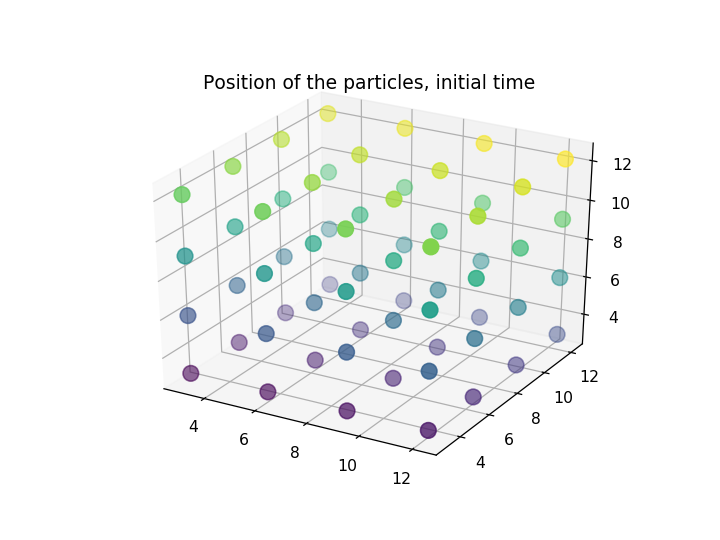

CPU times: user 14min 54s, sys: 1min 41s, total: 16min 36s
Wall time: 16min 46s


In [63]:
%%time
r, v = initial_conditions(N,L)

#Plot the initial positions of the particles
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.title('Position of the particles, initial time')

ax.scatter(r['x'],r['y'],r['z'],c=np.arange(N), s=100)
plt.show()

# Declare empty arrays to have information
K = []
U = []
TOT = []
T = [0]
V = [v]

# Obtain the particles positions:
Rx=[r['x'].reshape(N,)]
Ry=[r['y'].reshape(N,)]
Rz=[r['z'].reshape(N,)]

# Values for the boundaries conditions
values = np.array([-L,0,L])
letters = ['x','y','z']


for t in range(1,Nt+1):
    
    T.append(t)
    
    # Obtain the particles boundaries conditions (including centered ones):
    boundaries = np.array([[r[elem]+i for  i in values]for elem in letters])
    
    # In x, y, and z
    bx = boundaries[0]
    by = boundaries[1]
    bz = boundaries[2]
    
    # Obtain the x, y and z components
    B = []
    for i in range(3):
        for j in range(3):
            for k in range(3):
                B.append([bx[k],by[j],bz[i]])
    B=np.array(B)
    
    # Determine the positions of all the particles
    all_particles = np.split(np.array([B[:,:,0,i] for i in range(N)]).flatten(),27*N)
    
    #Obtain a numpy array with the principal positions
    rtot = np.array([r['x'],r['y'],r['z']])

    # Search for the x,y, and z position for each particle
    xyz_pos = np.array([rtot[:,:,i] for i in range(N)]).reshape((N,3))

    # Obtain a single vector that has the x, y and z components individually
    x_pos = r['x'].reshape((N,1))
    y_pos = r['y'].reshape((N,1))
    z_pos = r['z'].reshape((N,1))
    
    # Obtain the distances of all the particles with each other
    distances = sc_p.distance_matrix(xyz_pos,all_particles, p=2)
    distances = np.where(distances==0,np.nan,distances)
    # Determine the force of each interaction depending on the distance, if the distance is 0
    # then, the value will be Nan, so it is not affected somehow.
    forces = np.nan_to_num(calc_force(distances))
    
    # Obtain the components for all the particles
    x_all = np.array(all_particles)[:,0].reshape(N*27,1)
    y_all = np.array(all_particles)[:,1].reshape(N*27,1)
    z_all = np.array(all_particles)[:,2].reshape(N*27,1)

    # Generate distance matrices with relative position Rj-Ri
    x_pos1 = relative_position(x_pos,x_all)
    y_pos1 = relative_position(y_pos,y_all)
    z_pos1 = relative_position(z_pos,z_all)

    # Determine how much the force will affect each particle movement
    f = {'x':np.sum(forces*x_pos1,axis=1),'y':np.sum(forces*y_pos1,axis=1),'z':np.sum(forces*z_pos1, axis=1)}
    
    #Kinetic energy
    KE = .5*m*np.sum(v['x']**2+v['y']**2+v['z']**2)
    K.append(KE)
    
    #Potential energy
    PE = 0.5*np.sum(np.nan_to_num(U_pot(distances)))
    U.append(PE)
    
    #Total Energy
    TOT.append(KE + PE)
    # Change each velocity correspondingly
    v['x'] = v['x'] + f['x']/m*dt
    v['y'] = v['y'] + f['y']/m*dt
    v['z'] = v['z'] + f['z']/m*dt
    
    # Apply the thermostat to modify the velocity
    if t%tao==0:
        T_t = 2.0*KE/(3.0*N*KB)
        Lamb = np.sqrt(1.0 + dt/Tao*(T_INF/T_t-1))
        v['x']=Lamb*v['x']
        v['y']=Lamb*v['y']
        v['z']=Lamb*v['z']

    #Change each position correspondingly
    r['x'] = r['x'] + v['x']*dt + .5*f['x']/m*dt**2
    r['y'] = r['y'] + v['y']*dt + .5*f['y']/m*dt**2
    r['z'] = r['z'] + v['z']*dt + .5*f['z']/m*dt**2
    
    #Boundary conditions 
    r['x'] = np.where(r['x'] < 0, r['x'] + L, r['x'] )
    r['x'] = np.where(r['x'] > L, r['x'] - L, r['x'] )
    r['y'] = np.where(r['y'] < 0, r['y'] + L, r['y'] )
    r['y'] = np.where(r['y'] > L, r['y'] - L, r['y'] )
    r['z'] = np.where(r['z'] < 0, r['z'] + L, r['z'] )
    r['z'] = np.where(r['z'] > L, r['z'] - L, r['z'] )

    
    V.append(v)
    Rx.append(r['x'].reshape(N,))
    Ry.append(r['y'].reshape(N,))
    Rz.append(r['z'].reshape(N,))

<IPython.core.display.Javascript object>


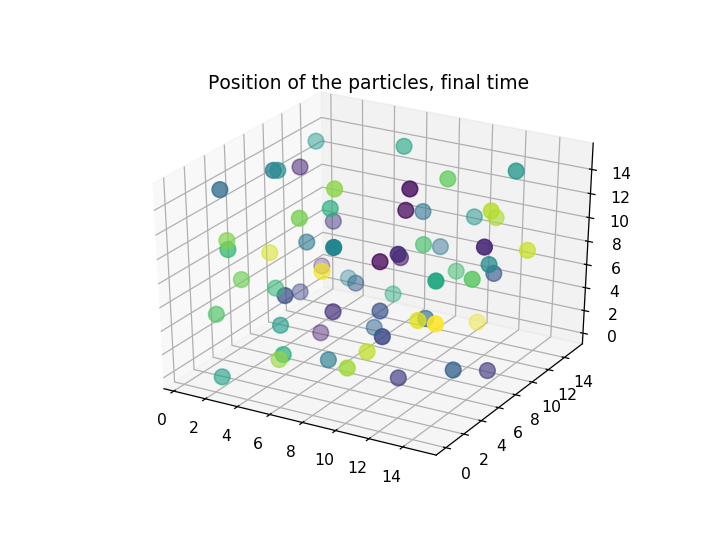

In [66]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(r['x'],r['y'],r['z'],c=np.arange(N), s=100)
plt.title('Position of the particles, final time')
plt.show()
x_df = pd.DataFrame(Rx,columns=[f"p{i+1}" for i in range(N)])
y_df = pd.DataFrame(Ry,columns=[f"p{i+1}" for i in range(N)])
z_df = pd.DataFrame(Rz,columns=[f"p{i+1}" for i in range(N)])

In [28]:
#colors = (np.array([np.arange(N)]*len(T))).flatten()
#fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
#plt.title('Trajectories')
#ax.scatter(x_df,y_df,z_df,c=colors, s=1)
#plt.show()

<IPython.core.display.Javascript object>


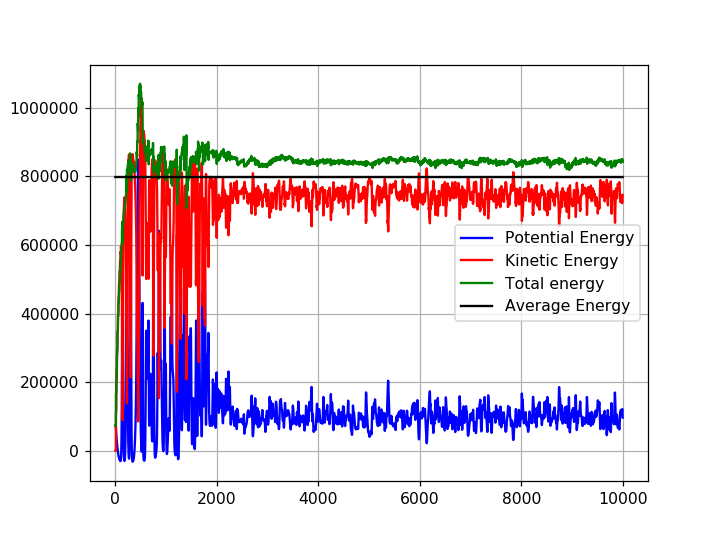

In [69]:
fig2=plt.figure()
plt.plot(T[:Nt-1],U[:Nt-1], label = 'Potential Energy', c='b')
plt.plot(T[:Nt-1],K[:Nt-1], label = 'Kinetic Energy', c='r')
plt.plot(T[:Nt-1], TOT[:Nt-1], label = 'Total energy', c = 'g')
plt.plot(T[:Nt-1],3/2*KB*N*T_INF*np.ones(Nt-1), label = 'Average Energy', c='k')
plt.grid()
plt.legend()

<IPython.core.display.Javascript object>


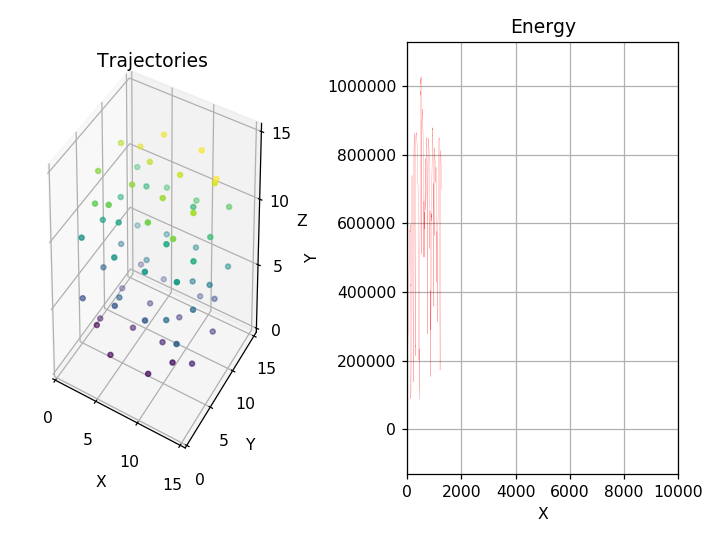

In [75]:
%matplotlib notebook

Writer = animation.writers['ffmpeg']
#writer = Writer(fps=300, bitrate=18)

fig3 = plt.figure()
ax1 = fig3.add_subplot(121,projection='3d')
sc = ax1.scatter(x_df.iloc[0],y_df.iloc[0],z_df.iloc[0], c=np.arange(N), s=10)

# Setting the axes limits and names
ax1.set_title('Trajectories')
ax1.set_xlim3d([0.0, L])
ax1.set_xlabel('X')
ax1.set_ylim3d([0.0, L])
ax1.set_ylabel('Y')
ax1.set_zlim3d([0.0, L])
ax1.set_zlabel('Z')




# 
ax2 = fig3.add_subplot(122)
sc2, = ax2.plot([],[], label = 'Kinetic Energy', c = 'r', linewidth=0.1)
#sc3, = ax2.plot([],[], label = 'Potential Energy', c = 'b')
#sc4, = ax2.plot([],[], label = 'Total Energy', c = 'g')
ax2.grid()
#ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))


ax2.set_title('Energy')
ax2.set_xlim([0.0, max(T)])
ax2.set_xlabel('X')
ax2.set_ylim([min(U)-100000, max(K)+100000])
ax2.set_ylabel('Y')


def animate(i):
    sc2.set_data(T[0:i], K[0:i])
    sc3.set_data(T[0:i], U[0:i])
    sc4.set_data(T[0:i], np.array(K[:i])+np.array(U[:i]))
    sc._offsets3d = (x_df.iloc[i],y_df.iloc[i],z_df.iloc[i])
    

plt.tight_layout()
ani = animation.FuncAnimation(fig3, animate, interval=1,frames=len(x_df), repeat=True)
plt.show()